#基底関数モデルによる非線形回帰
今回のPython演習では基底関数モデルに基づく非線形回帰に取り組みたいと思います．いつもどおりMoodleのデモ動画を見ながら進めていきましょう！

#1. 株価変動データ
今回は，株価変動の時系列データをモデリングしてみたいと思います．このようなデータを扱う場合は[自己回帰モデル](https://www.google.com/search?q=%E8%87%AA%E5%B7%B1%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB)の方が一般的だと思いますが，あくまで講義で紹介した**基底関数モデルを理解するための題材**として考えてください．

まずは，以下のプログラムを実行してどのようなデータか見ていきましょう．

done


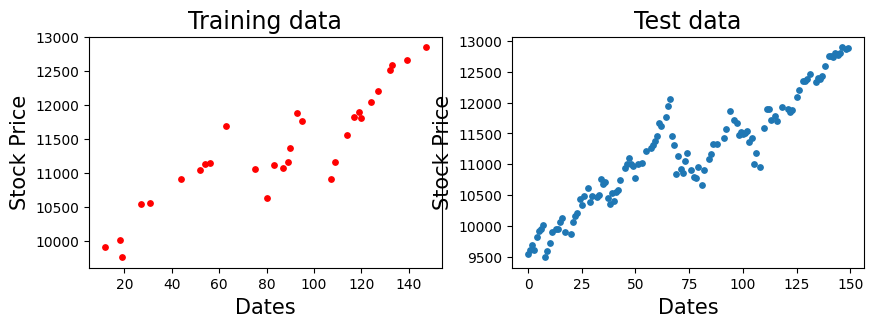

In [44]:
#@title データの読み込みと可視化
%matplotlib inline
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt

start = datetime.datetime(2020,6,1)
end   = datetime.datetime(2021,1,1)

data = web.DataReader('NASDAQCOM','fred',start,end).dropna(how='all')
y_true = data.values[:,0]

N = len(y_true)
Ntrain = round(0.2*N)
Ntest  = N - Ntrain

index = np.random.permutation(N)
index_train = np.sort(index[0:Ntrain])
index_test  = np.sort(index[Ntrain:N])

y_train = y_true[index_train]
y_test  = y_true[index_test]

fig  = plt.figure(figsize=(10,3))
axes = fig.subplots(1,2)
axes[0].scatter(index_train, y_train, c='red', s=15)
axes[0].set_ylabel('Stock Price', fontsize=15)
axes[0].set_xlabel('Dates', fontsize=15)
axes[0].set_title('Training data', fontsize=17)
axes[1].scatter(index_test, y_test, s=15)
axes[1].set_ylabel('Stock Price', fontsize=15)
axes[1].set_xlabel('Dates', fontsize=15)
axes[1].set_title('Test data', fontsize=17)
print('done')

プログラムを実行すると，左に訓練データ(Training data)，右にテストデータ(Test data)が表示されると思います．以下の手順で演習を行っていきます．
* **基底関数モデルを定義**する
* **訓練データとの二乗誤差**に基づいて基底関数モデルを最適化する
* 最適化した基底関数モデルを**テストデータとの二乗誤差**によって評価する


# 2. 基底関数モデルの定義
まずは，基底関数モデルを定義します．株価を$y$，時間を$x$とおきます．モデルに期待する機能は$x$を入力したときに$y$を推定することです．つまり，$y$の推定値は$\hat{y} = f(x)$の式で与えられます．ここで関数$f(x)$がモデルです．

パラメータ$\boldsymbol{\beta}$を用いて，基底関数モデルを以下のように定義します．<br>
基底関数モデル：$f(x|\boldsymbol{\beta}) = \boldsymbol{\beta}^\top \boldsymbol{h}(x)$<br>
基底関数モデルの性質は基底関数によって決まります．本演習では以下の2種類の基底関数を使っていきたいと思います．
* 多項式関数 ($1, x, x^2, x^3, ...$)
* 三角関数 ($\sin, \cos, \tan$)

##2.1 多項式基底関数の生成
$k$次の多項式基底関数を以下の式で定義します．<br>
基底関数：$h_p(x,k) := \left(\frac{x - \mu}{\mu}\right)^k$<br>
ただし，$\mu = \frac{N-1}{2}$と置きます．
次に，$k=0$から$k=K$までの基底関数を並べて以下のベクトル値関数を考えます．<br>
$\boldsymbol{h}_p(x) := \begin{pmatrix} h_p(x,0) \\ h_p(x,1) \\ \vdots \\ h_p(x,K) \end{pmatrix} = \begin{pmatrix} \left(\frac{x - \mu}{\mu}\right)^0 \\ \left(\frac{x - \mu}{\mu}\right)^1 \\ \vdots \\ \left(\frac{x - \mu}{\mu}\right)^K \end{pmatrix}$<br>
<font size=2 color=gray>
【ちょこっと解説】まず，$k=0$の時は任意の入力で1となるので，切片項のようなものです．また，$k=1$のときは1次の項+定数項に分解でき，定数項は$k=0$に吸収されるので本質的には傾き項が重要となります．$k$が大きい場合でも，展開すれば$k$以下の項しか出てこないため，本質的には$k$次の項が重要となります．任意の$\boldsymbol{\beta}$に対応する$\boldsymbol{\alpha}$が存在して，$f(x|\boldsymbol{\beta}) = \sum_{k=0}^K \alpha_k x^k$を満たします．ただし，$x^k$をそのまま基底関数として計算してしまうと，$x$と$k$の両者が大きいときにはコンピュータ上で処理できないほど大きな値を持ってしまいます．今回の多項式基底関数の定義を採用すれば$x \in [0, N-1]$のときに$-1 \leq h_p(x,k) \leq 1$を満たすため，すこし計算が安定します．（$k$をさらに大きくすると今度は他の問題がでてきます．．．）
</font>

それではプログラムを完成させ，多項式基底関数を生成していきましょう．
実際には，xが$\{0, 1, 2, ..., N-2, N-1\}$ (計N個) の値を取ると仮定し，行列$Z_p \in \mathbb{R}^{N \times (K+1)} $を作ります．

In [45]:
Kmax = 15

Zp = np.zeros([N,Kmax+1])
x  = np.array(range(0,N))
mu = (N-1)/2# input here

for k in range(Kmax+1):
  Zp[:,k] = ((x-mu)/mu)**k# input here

done


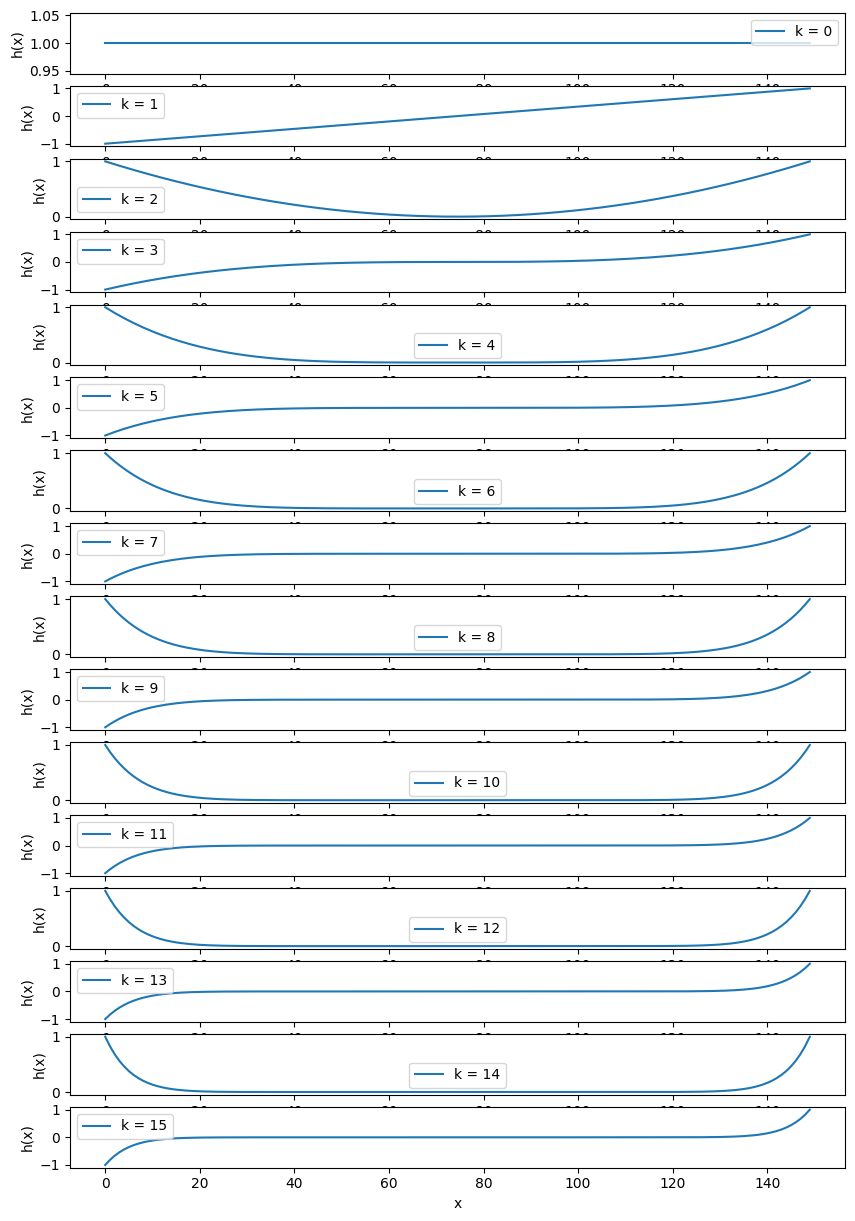

In [5]:
#@title 多項式基底関数の可視化
%matplotlib inline
fig  = plt.figure(figsize=(10,15))
axes = fig.subplots(Kmax+1, 1)
for k in range(Kmax+1):
  lname = 'k = '+str(k)
  axes[k].plot(Zp[:,k],label=lname)
  axes[k].set_ylabel('h(x)', fontsize=10)
  axes[k].set_xlabel('x', fontsize=10)
  axes[k].legend(fontsize=10)
print('done')

## 2.2 コサイン基底関数の生成
$k$番目のコサイン基底関数を以下の式で定義します．<br>
基底関数：$h_c(x,k) := \cos\left[ \frac{k\pi}{N}(x + \frac{1}{2}) \right]$<br>
次に，$k=0$から$k=K$までの基底関数を並べて以下のベクトル値関数を考えます．
$\boldsymbol{h}_c(x) := \begin{pmatrix} h_c(x,0) \\ h_c(x,1) \\ \vdots \\ h_c(x,K) \end{pmatrix} = \begin{pmatrix} \cos\left[ \frac{0\pi}{N}(x + \frac{1}{2}) \right] \\ \cos\left[ \frac{\pi}{N}(x + \frac{1}{2}) \right] \\ \vdots \\ \cos\left[ \frac{K\pi}{N}(x + \frac{1}{2}) \right] \end{pmatrix} = \begin{pmatrix} 1 \\ \cos\left[ \frac{\pi}{N}(x + \frac{1}{2})\right] \\ \vdots \\  \cos\left[ \frac{K\pi}{N}(x + \frac{1}{2})\right] \end{pmatrix}$<br>
<font size=2 color=gray>
【ちょこっと解説】コサイン関数なので基底関数の値は常に $-1 \leq h_c(x,k) \leq 1$ を満たします．また，0番目に関しては$\cos(0)=1$で定数項となります．余談ですが実はこの基底関数はJPEG画像圧縮に使われています．
</font>

それではプログラムを完成させ，コサイン基底関数を生成していきましょう．
実際には，xが$\{0, 1, 2, ..., N-2, N-1\}$ (計N個) の値を取ると仮定し，行列$Z_c \in \mathbb{R}^{N \times (K+1)} $を作ります．

In [46]:
import math

Zc = np.zeros([N,Kmax+1])
x  = np.array(range(0,N))

for k in range(Kmax+1):
  Zc[:,k] = np.cos((k*math.pi)/N*(x+0.5))# input here

done


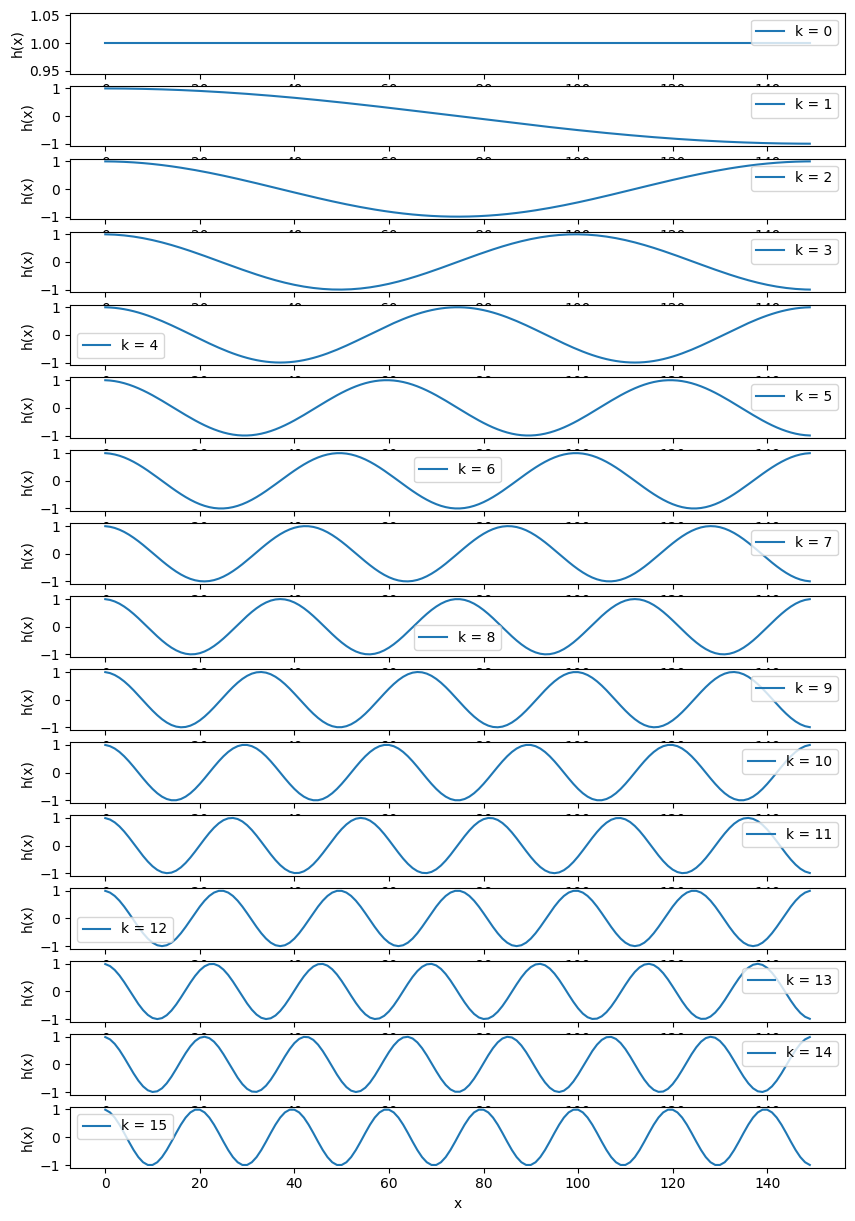

In [36]:
#@title コサイン基底関数の可視化
%matplotlib inline
fig  = plt.figure(figsize=(10,15))
axes = fig.subplots(Kmax+1, 1)
for k in range(Kmax+1):
  lname = 'k = '+str(k)
  axes[k].plot(Zc[:,k],label=lname)
  axes[k].set_ylabel('h(x)', fontsize=10)
  axes[k].set_xlabel('x', fontsize=10)
  axes[k].legend(fontsize=10)
print('done')

## 2.3 基底関数モデルに基づく曲線の生成
2種類の基底関数$\boldsymbol{h}_p(x)$，$\boldsymbol{h}_c(x)$を作りました．これに対して係数$\boldsymbol{\beta} \in \mathbb{R}^{K+1}$を掛け合わせることで，さまざまな関数を作ることができます．

試しに，$\boldsymbol{\beta}$をランダムに生成して関数を生成してみましょう．実行するたびに異なる関数が生成されます．何回か試してみてください．

done


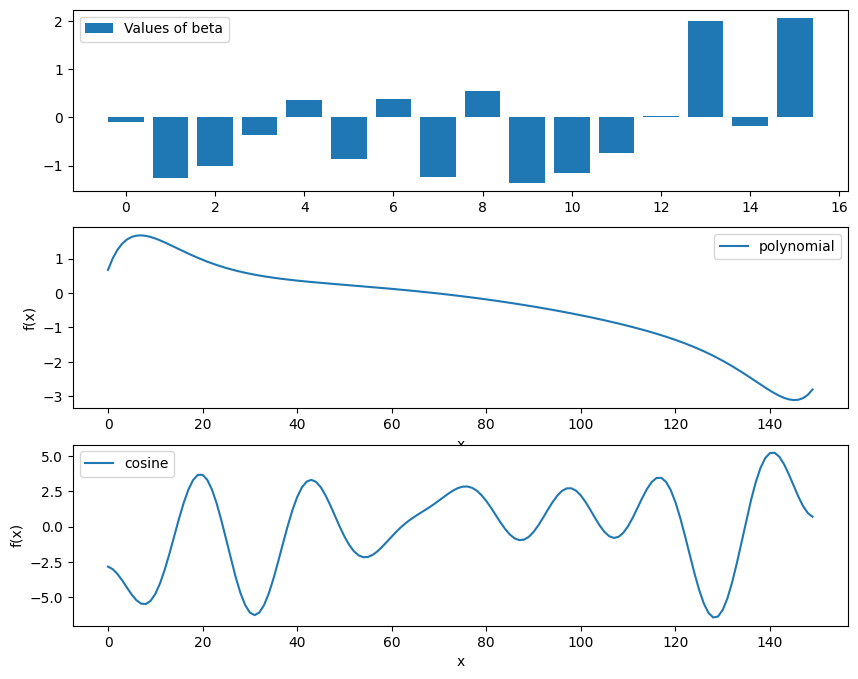

In [47]:
#betaの生成
beta = np.random.randn(Kmax+1, 1) # input here

f_p = np.dot(Zp, beta)# input here
f_c = np.dot(Zc, beta)# input here

fig  = plt.figure(figsize=(10,8))
axes = fig.subplots(3, 1)
axes[0].bar(np.array(range(Kmax+1)),beta[:,0], label='Values of beta')
axes[0].legend(fontsize=10)
axes[1].plot(f_p,label='polynomial')
axes[1].set_ylabel('f(x)', fontsize=10)
axes[1].set_xlabel('x', fontsize=10)
axes[1].legend(fontsize=10)
axes[2].plot(f_c,label='cosine')
axes[2].set_ylabel('f(x)', fontsize=10)
axes[2].set_xlabel('x', fontsize=10)
axes[2].legend(fontsize=10)

print('done')

# 3. 基底関数モデルのフィッティング
いよいよ基底関数モデルの係数$\boldsymbol{\beta}$を最適化し，訓練データにフィッティングしていきます．

訓練データを$\{y_i, x_i \}_{i=1}^{N_\text{train}}$として，二乗誤差$\sum_{i=1}^{N_\text{train}} (y_i - f(x_i; \boldsymbol{\beta}))^2 $が最小となるようなパラメータ$\boldsymbol{\beta}$を求めます．

最小二乗法に基づくパラメータの推定値$\hat{\boldsymbol{\beta}} = [\hat{\beta}_0, ..., \hat{\beta}_K]^\top$は以下の式で与えられます．
$$\hat{\boldsymbol{\beta}} = (Z^\top Z)^{-1}Z^\top \boldsymbol{y}$$

ここで行列$Z \in \mathbb{R}^{N_\text{train} \times (K+1)}$の各要素は$z_{im} = h(x,m-1)$で与えられます．

では，プログラミングしていきましょう．繰り返し処理で，$K=0$の場合から$K=15$まで一気に求めてしまいましょう．


In [48]:
%matplotlib inline
y_train  = y_true[index_train]

Yp_est=np.zeros([N, Kmax+1])
Yc_est=np.zeros([N, Kmax+1])
for K in range(Kmax+1):
  #polynomial
  Zp_train = Zp[index_train,0:K+1]
  A = np.dot(Zp_train.T, Zp_train)# input here
  b = np.dot(Zp_train.T, y_train)# input here
  beta_p = np.linalg.inv(A).dot(b)
  y_est = np.dot(Zp[:,0:K+1], beta_p)
  Yp_est[:,K] = y_est
  #cosine
  Zc_train = Zc[index_train,0:K+1]
  A = np.dot(Zc_train.T, Zc_train)# input here
  b = np.dot(Zc_train.T, y_train)# input here
  beta_c = np.linalg.inv(A).dot(b)
  y_est = np.dot(Zc[:,0:K+1], beta_c)
  Yc_est[:,K] = y_est

print('done')

done


## 4. 最適化した関数モデルの評価
最後に，最適化した基底関数モデルを評価していきます．まずは，得られた関数がどのぐらい訓練データにフィット(適合)しているのかを見ていきたいと思います．

$K$の値を変えて，どのような違いあるかを観察してみましょう．

done


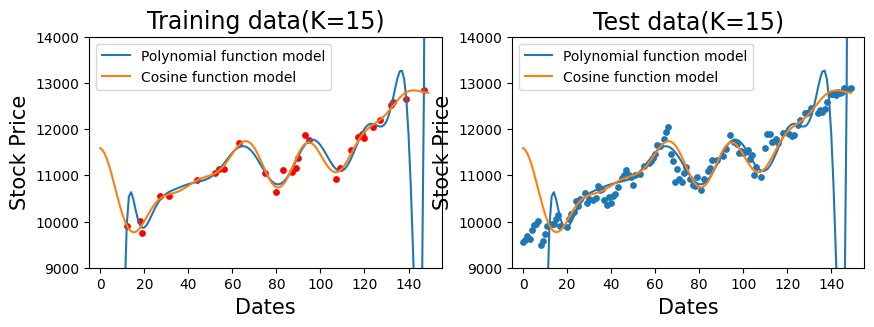

In [53]:
K = 15 #ココの値を0から15の範囲でいろいろ変えて実行してみてください．

fig  = plt.figure(figsize=(10,3))
axes = fig.subplots(1,2)
axes[0].scatter(index_train, y_train, c='red', s=15)
axes[0].plot(Yp_est[:,K], label='Polynomial function model')
axes[0].plot(Yc_est[:,K], label='Cosine function model')
axes[0].set_ylabel('Stock Price', fontsize=15)
axes[0].set_xlabel('Dates', fontsize=15)
axes[0].set_title('Training data(K='+str(K)+')', fontsize=17)
axes[0].set_xlim([-5, 155])
axes[0].set_ylim([9000, 14000])
axes[0].legend(fontsize=10)
axes[1].scatter(index_test, y_test, s=15)
axes[1].plot(Yp_est[:,K], label='Polynomial function model')
axes[1].plot(Yc_est[:,K], label='Cosine function model')
axes[1].set_ylabel('Stock Price', fontsize=15)
axes[1].set_xlabel('Dates', fontsize=15)
axes[1].set_title('Test data(K='+str(K)+')', fontsize=17)
axes[1].set_xlim([-5, 155])
axes[1].set_ylim([9000, 14000])
axes[1].legend(fontsize=10)
print('done')

## 4.1 定量評価
結果を目で見ることはとても重要ですが，最適化したモデルの良さを定量的に評価することも同様に重要です．特に，高次元データのフィッティングなど，結果を目で見ることが難しい場合も多くあります．

まず，訓練データへの適合度を見るために，平均二乗誤差(MSE: Mean Squared Error)を計算してみましょう．訓練データ$\{y_i, x_i \}_{i=1}^{N_\text{train}}$に関するMSEは<br>
$\text{MSE} = \frac{1}{N_\text{train}}\sum_{i=1}^{N_\text{train}}(y_i - f(x_i | \hat{\boldsymbol{\beta}}))^2$<br>
によって得られます．

次に，未知のデータに対する予測の正確さと評価するために，テストデータを用います．テストデータの集合を$\{\tilde{y}_j, \tilde{x}_j \}_{j=1}^{N_\text{test}}$として，MSEを以下の式で計算します．<br>
$ \text{MSE} := \frac{1}{N_\text{test}} \sum_{j=1}^{N_\text{test}}\left( \tilde{y}_j - f(\tilde{x}_j | \hat{\boldsymbol{\beta}}) \right)^2 $<br>

それでは，プログラムを完成させていきましょう．$K$が変わったときの，訓練MSEとテストMSEがどのうように変化するかを観察してみましょう．

done


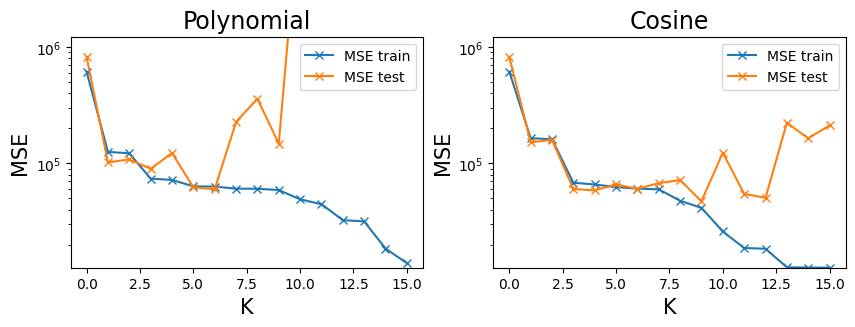

In [50]:
%matplotlib inline

y_train  = y_true[index_train]
y_test   = y_true[index_test]
MSEp_train = np.zeros([Kmax+1])
MSEp_test  = np.zeros([Kmax+1])
MSEc_train = np.zeros([Kmax+1])
MSEc_test  = np.zeros([Kmax+1])
for K in range(Kmax+1):
  yp_est = Yp_est[:,K]
  yp_est_train = yp_est[index_train]
  yp_est_test  = yp_est[index_test]
  MSEp_train[K] = np.mean((y_train - yp_est_train)**2)# input here
  MSEp_test[K]  = np.mean((y_test - yp_est_test)**2)# input here
  yc_est = Yc_est[:,K]
  yc_est_train = yc_est[index_train]
  yc_est_test  = yc_est[index_test]
  MSEc_train[K] = np.mean((y_train - yc_est_train)**2)# input here
  MSEc_test[K]  = np.mean((y_test - yc_est_test)**2)# input here

ymin = np.min(MSEc_train)
ymax = np.max(MSEc_train)

fig  = plt.figure(figsize=(10,3))
axes = fig.subplots(1,2)
axes[0].plot(MSEp_train, 'x-', label='MSE train')
axes[0].plot(MSEp_test, 'x-', label='MSE test')
axes[0].set_ylabel('MSE', fontsize=15)
axes[0].set_xlabel('K', fontsize=15)
axes[0].set_title('Polynomial', fontsize=17)
axes[0].legend(fontsize=10)
axes[0].set_yscale('log')
axes[0].set_ylim([ymin, ymax*2])
axes[1].plot(MSEc_train, 'x-', label='MSE train')
axes[1].plot(MSEc_test, 'x-', label='MSE test')
axes[1].set_ylabel('MSE', fontsize=15)
axes[1].set_xlabel('K', fontsize=15)
axes[1].set_title('Cosine', fontsize=17)
axes[1].legend(fontsize=10)
axes[1].set_yscale('log')
axes[1].set_ylim([ymin, ymax*2])
print('done')

お疲れ様でした．今日の演習はここまでです．
提出内容は以下3点の写真です．
*   4節でK=1，K=10，K=15の時を3通り実行し，それぞれで出力された図の写真を撮ってください．(3枚)
*   4.1節で出力された図の写真を撮ってください．(1枚)
*   4.1節の図について，以下の質問に答えてください．紙に回答を書いて写真を撮ってください．(1枚)
  *  青い線が示しているものは何か？
  *  オレンジの線が示しているものは何か？
  *  「過学習」と呼ばれる現象はどのようなときに起きているか？

以上(5枚の写真)をまとめてMoodleから提出してください．